## A better Kaggle post:

https://www.kaggle.com/prasathm2001/undersampling-in-wine-quality

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, mean_squared_error

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../../data/winequality-red.csv')

## EDA

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Box Plots

<AxesSubplot:xlabel='quality', ylabel='fixed acidity'>

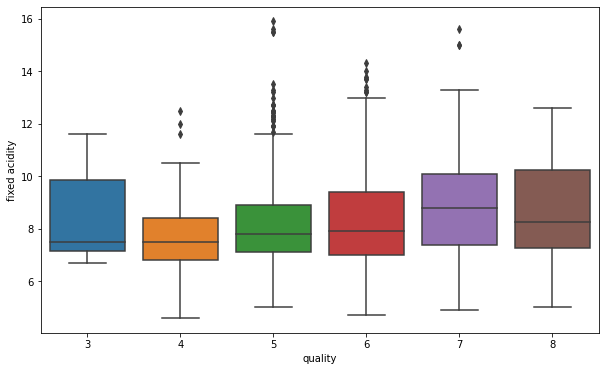

In [5]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'quality', y = 'fixed acidity', data = df)

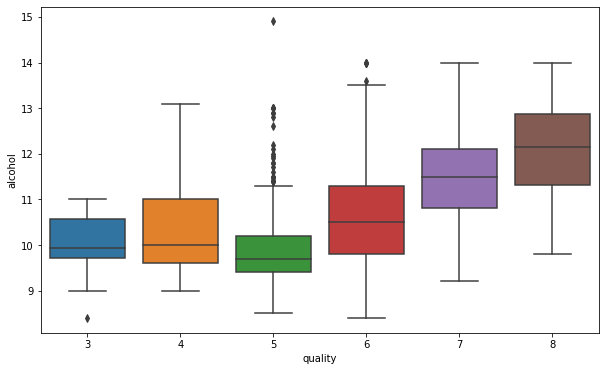

In [7]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'quality', y = 'alcohol', data = df);

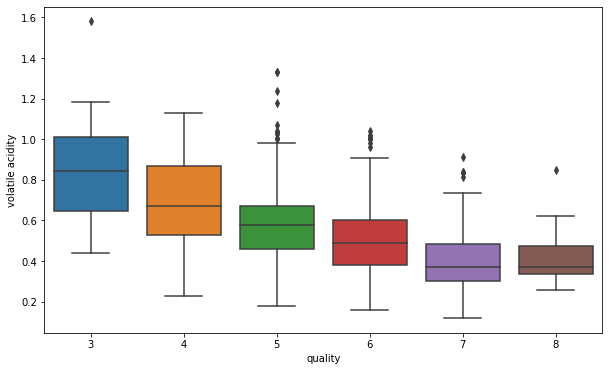

In [8]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'quality', y = 'volatile acidity', data = df);

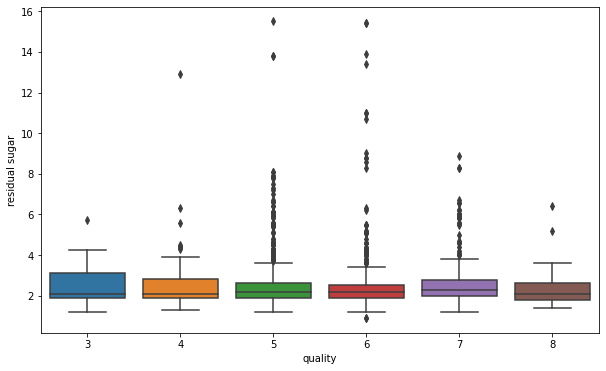

In [9]:
fig = plt.figure(figsize = (10,6))
sns.boxplot(x = 'quality', y = 'residual sugar', data = df);

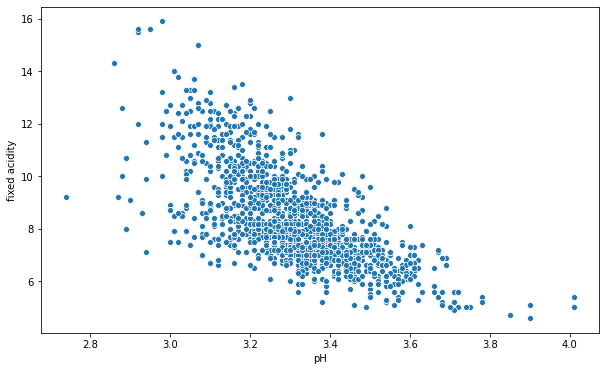

In [13]:
fig = plt.figure(figsize = (10,6))
sns.scatterplot(x = 'pH', y = 'fixed acidity', data = df);

/home/asa/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


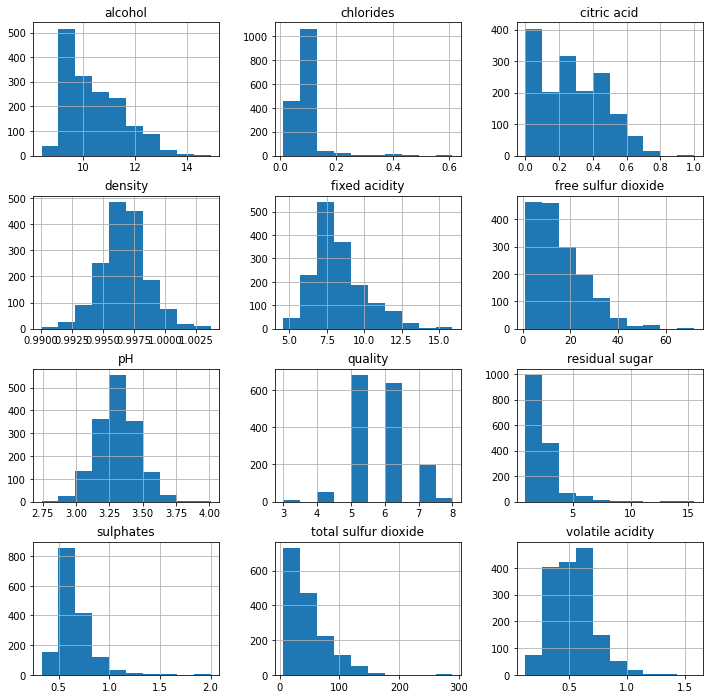

In [4]:
df.hist(figsize=(12,12));

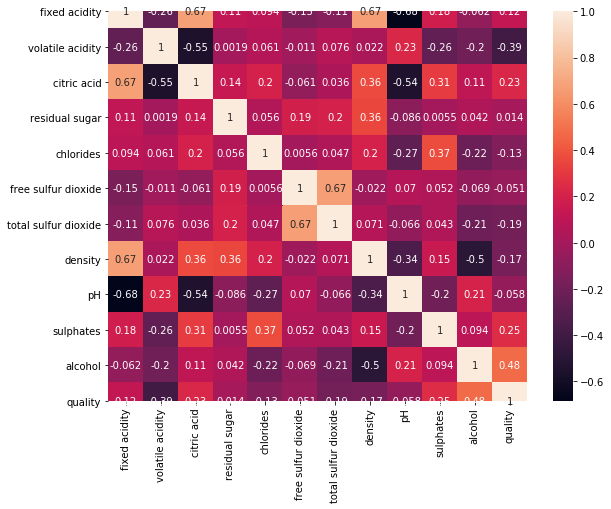

In [35]:
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(8,6))
plt.tight_layout()
sns.heatmap(data=corr_mat, annot=True, ax=ax);

In [33]:
import matplotlib
print(matplotlib.__version__)

3.1.1


## Initial Models

### Model common code

In [68]:
y = df['quality']
X = df.drop(['quality'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 42)

In [69]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [107]:
def run_models(models, X_train, X_test, y_train, y_test):
    print(f'Model\t\t\tScore')
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = model.score(X_test, y_test)
        print(f'{type(model).__name__}\t\t{score:0.5f}')

In [110]:
models = [LinearRegression(), 
          Lasso(alpha = 0.0001, random_state=42), 
          Ridge(alpha = 0.0001, random_state=42), 
          ElasticNet(alpha = 0.0001, random_state=42),
          RandomForestRegressor(random_state=42)]
run_models(models, X_train_scaled, X_test_scaled, y_train, y_test)

Model			Score
LinearRegression		0.40318
Lasso		0.40311
Ridge		0.40318
ElasticNet		0.40315
RandomForestRegressor		0.53993


### Linear Regression

In [70]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

In [71]:
lr.score(X_test_scaled, y_test)

0.403180341279622

In [73]:
mean_absolute_error(y_test, y_pred)

0.5035304415524375

In [77]:
r2_score(y_test, y_pred)

0.403180341279622

In [75]:
mean_squared_error(y_pred, y_test, squared = True)

0.3900251439639549

In [76]:
mean_squared_error(y_pred, y_test, squared = False)

0.6245199307980129

In [80]:
explained_variance_score(y_test, y_pred)

0.40484356627137197

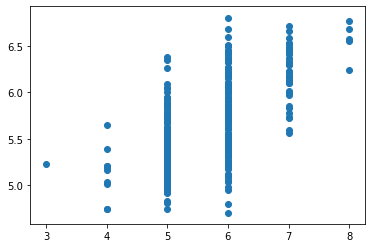

In [79]:
plt.scatter(y_test, y_pred)
plt.